# Reinforcement learning

## Goal and perspectives

This tutorial is mainly adapted from this article https://arxiv.org/pdf/2103.06294.pdf and inspired by the work done during the 2022 LOQCathon.

### Reinforcement learning

Reinforcement learning is a machine learning framework where an agent tries to find the right actions to perform by interacting with an environment. This is modelled by an agent who is taking actions and receiving percepts from the environment which can be used to choose the next actions. At the end of an epoch (or a series of epochs), the environment rewards (or not) the agent according to the string of actions taken. From the reward, the agent learns and adapts their strategy for the next epochs.

![reinforcement_learning.png](../_static/img/reinforcement-learning_reinforcement_learning.png)

In Quantum Reinforcement learning, the exchanged actions, percepts and rewards are now quantum states being exchanged between the environment and the agent. In their paper, the authors claimed to have found a quantum advantage in the time for training by making use of Grover's amplification method to reach good actions quicker, and the goal of this tutorial is to reproduce the main results of their paper:

![results_paper.png](../_static/img/reinforcement-learning_results_paper.png)


## Imports of packages and configuration of display

In [22]:
from typing import Union

from ipywidgets import FloatProgress
from IPython.display import display

import perceval as pcvl
import numpy as np
import matplotlib.pyplot as plt
from perceval.components.unitary_components import Unitary, BS, PS
from perceval.rendering.circuit import DisplayConfig, SymbSkin

DisplayConfig.select_skin(SymbSkin)

## Grover's algorithm

We will now implement Grover's algorithm, firstly from a high-level picture (using unitaries) and then photonically (using Mach-Zehnder interferometers) in the same way that was done in the article.

### Grover's algorithm in high-level picture

In [23]:
# Let's create a function that generates our circuit, given an angle xi

def grover_circuit_unitaries(xi:float) -> pcvl.Circuit:
    # Unitary to go from |00> to cos(xi)|10> + sin(xi)|01>
    unitary_p = pcvl.Matrix(
        np.array([[np.cos(xi), -np.sin(xi)], [np.sin(xi), np.cos(xi)]])
    )
    # Unitary for Hadamard gate
    unitary_hadamard = pcvl.Matrix(1 / np.sqrt(2) * np.array([[1, 1], [1, -1]]))
    # Unitary for environment interaction, that switches the phase of the good state
    unitary_env = pcvl.Matrix(np.array([[0, -1], [-1, 0]]))
    # Unitary of the reflection
    unitary_reflection = pcvl.Matrix(
        np.array(
            [
                [np.cos(2 * xi), np.sin(2 * xi)],
                [np.sin(2 * xi), -np.cos(2 * xi)],
            ]
        )
    )
    
    # We can now assemble our circuit
    hadamard_component = Unitary(unitary_hadamard, "H")
    circuit = pcvl.Circuit(4) // (1, Unitary(unitary_p, "P")) // (0, hadamard_component) // (2, hadamard_component) // (2, Unitary(unitary_env, "env"))\
              // (0, hadamard_component) // (2, hadamard_component) // (1, Unitary(unitary_reflection, "reflection"))
    return circuit

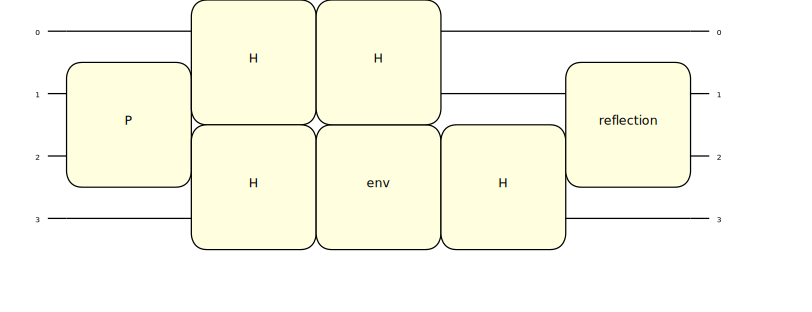

In [24]:
pcvl.pdisplay(grover_circuit_unitaries(np.pi/3))

One step of amplitude amplification in Grover's algorithm should rotate our state from a $\xi$ angle to a $3\xi$ angle from the loosing state to the winning state. Hence we can check the validity of our Grover's amplification algorithm by inputting a photon in the spatial mode 1 and detecting at spatial mode 2. This should follow a $\sin(3\xi)^2$ distribution.

In [25]:
xis = np.linspace(0, np.pi/2, 100)
results = []
for xi in xis:
    circuit = grover_circuit_unitaries(xi)
    
    backend = pcvl.BackendFactory().get_backend()
    
    simulator = backend(circuit)
    input_state = pcvl.BasicState([0, 1, 0, 0])
    
    results.append(simulator.prob(input_state, pcvl.BasicState([0, 0, 1, 0])))

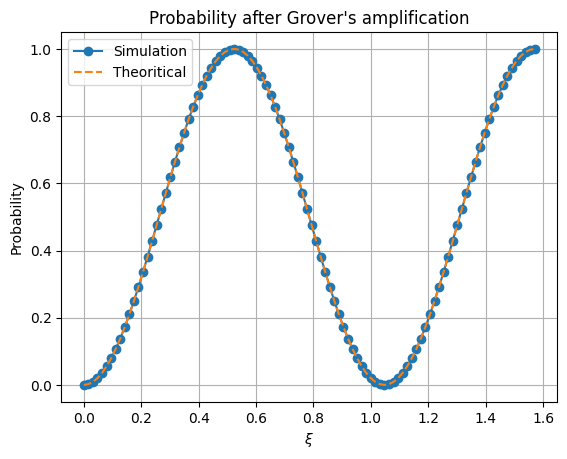

In [26]:
plt.plot(xis, results, "-o", label="Simulation")
plt.plot(xis, np.sin((3*xis)) ** 2, "--", label="Theoritical")
plt.title("Probability after Grover's amplification")
plt.xlabel("$\\xi$")
plt.ylabel("Probability")
plt.grid()
plt.legend()

### Designing the circuit with Mach-Zehnder interferometers

In the article they have used Mach-Zehnder interferometers (see below) to realize all the circuits.

![mzi.png](../_static/img/reinforcement-learning_mzi.png)


We want to perform the following unitary transformation (equation A.19 in the paper)

$$U_{\theta,\varphi} = \begin{pmatrix}e^{i\varphi}\sin\left(\frac{\theta}{2}\right) & e^{i\varphi}\cos\left(\frac{\theta}{2}\right)\\ \cos\left(\frac{\theta}{2}\right) & -\sin\left(\frac{\theta}{2}\right) \end{pmatrix}$$

However taking the MZI as shown and using the Rx convention for beam splitters yields the following matrix (see documentation [here](https://perceval.quandela.net/docs/components.html#beam-splitter)).


$$ie^{i\frac{\theta}{2}}\begin{pmatrix}e^{i\varphi}\sin\left(\frac{\theta}{2}\right) & e^{i\varphi}\cos\left(\frac{\theta}{2}\right)\\ \cos\left(\frac{\theta}{2}\right) & -\sin\left(\frac{\theta}{2}\right) \end{pmatrix}$$

To remove this global phase effect, we use phase shifters with angle $\theta_2$ to be $-\frac \pi 2 - \frac \theta 2$:

In [27]:
def mzi(name:str, theta:Union[float, pcvl.Parameter], phi:Union[float, pcvl.Parameter],theta_2:Union[float, pcvl.Parameter]) -> pcvl.Circuit:
    # For the mzi to be in the right shape:
    #   theta_2 should be set to '- pi/2 - theta/2'
    #   however we cannot pass a symbolic expression to the input of PS
    #   so we need to define a third angle theta_2 that we will set to '- pi/2 - theta/2' later on
    return (
        pcvl.Circuit(2, name=name)
        .add(0, BS())
        .add(0, PS(theta))
        .add(0, BS())
        .add(0, PS(phi))
        .add(0, PS(theta_2))
        .add(1, PS(theta_2))
    )


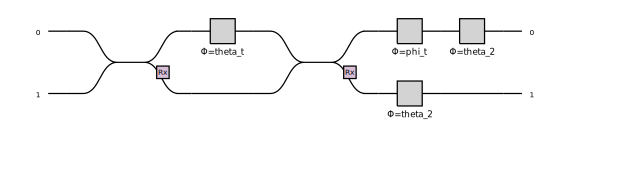

In [28]:
theta_t = pcvl.P("theta_t")
phi_t = pcvl.P("phi_t")
theta_2 = pcvl.P("theta_2")

pcvl.pdisplay(mzi("test", theta_t, phi_t, theta_2))

#### Implementing the gates with MZI

##### Hadamard

For the Hadamard, we want $\theta$ and $\varphi$ such that

$$\begin{pmatrix}e^{i\varphi}\sin\left(\frac{\theta}{2}\right) & e^{i\varphi}\cos\left(\frac{\theta}{2}\right)\\ \cos\left(\frac{\theta}{2}\right) & -\sin\left(\frac{\theta}{2}\right) \end{pmatrix} = \frac{1}{\sqrt{2}}\begin{pmatrix}1 & 1\\ 1 & -1 \end{pmatrix}$$

so we set $\theta = \frac{\pi}{2}$ and $\varphi = 0$.

In [29]:
hadamard = mzi("H", np.pi/2, 0, -np.pi/2 - np.pi/4)

pcvl.pdisplay(hadamard.U)

##### Environnement
For the environnement, we want a matrix of the form

$$\begin{pmatrix}e^{i\varphi}\sin\left(\frac{\theta}{2}\right) & e^{i\varphi}\cos\left(\frac{\theta}{2}\right)\\ \cos\left(\frac{\theta}{2}\right) & -\sin\left(\frac{\theta}{2}\right) \end{pmatrix} = \begin{pmatrix}0 & -1\\ -1 & 0 \end{pmatrix}$$

which gives $\theta = -2\pi$ and $\varphi=0$.

In [30]:
env = mzi("U_E", -2 * np.pi, 0, -np.pi/2 + np.pi)

pcvl.pdisplay(env.U)

##### Preparation of state

For the preparation of the state, we want a matrix of the form


$$\begin{pmatrix}e^{i\varphi}\sin\left(\frac{\theta}{2}\right) & e^{i\varphi}\cos\left(\frac{\theta}{2}\right)\\ \cos\left(\frac{\theta}{2}\right) & -\sin\left(\frac{\theta}{2}\right) \end{pmatrix} = \begin{pmatrix}\cos(\xi) & -\sin(\xi)\\ \sin(\xi) & \cos(\xi) \end{pmatrix}$$

which gives $\theta = \pi - 2\xi$ and $\varphi=0$.


In [31]:
theta_prep = pcvl.P("theta_prep") # We will set it to pi - 2*xi later
theta2_prep = pcvl.P("theta2_prep") # We will set it to -pi/2 - pi/2 + xi = -pi + xi later as we cannot pass symbolic expression to the function mzi
state_prep = mzi("U_p", theta_prep, 0, theta2_prep)

##### Reflection

For the reflection, we want a matrix of the form 

$$\begin{pmatrix}e^{i\varphi}\sin\left(\frac{\theta}{2}\right) & e^{i\varphi}\cos\left(\frac{\theta}{2}\right)\\ \cos\left(\frac{\theta}{2}\right) & -\sin\left(\frac{\theta}{2}\right) \end{pmatrix} = \begin{pmatrix}\cos(2\xi) & \sin(2\xi)\\ \sin(2\xi) & -\cos(2\xi) \end{pmatrix}$$

which gives $\theta = \pi - 4\xi$ and $\varphi=0$

In [32]:
theta_ref = pcvl.P("theta_ref") # We will set it to pi - 4*xi later
theta2_ref = pcvl.P("theta2_ref") # We will set it to -pi/2 - pi/2 + 2xi = -pi + 2xi later as we cannot pass symbolic expression to the function mzi
ref = mzi("U_ref", theta_ref, 0, theta2_ref)

### Grover's algorithm with MZI

We now implement again Grover's algorithm with MZI implementation as a sanity check for the definitions of the gates we chose.

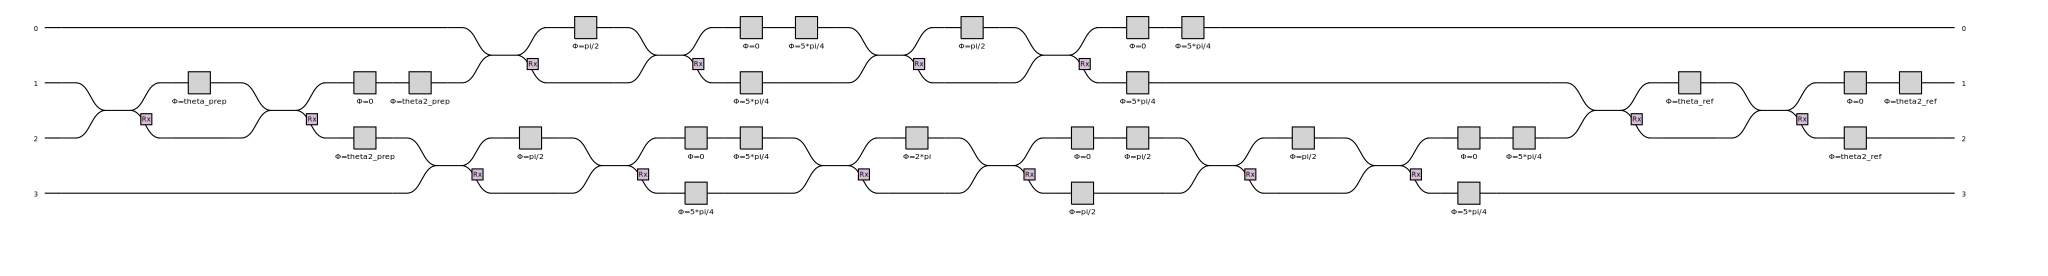

In [33]:
circuit = pcvl.Circuit(4)
circuit.add(1, state_prep).add(0, hadamard).add(2, hadamard).add(2, env).add(0, hadamard).add(2, hadamard).add(1, ref)

pcvl.pdisplay(circuit)

In [34]:
results_mzis = []

for xi in xis:
    # Update values in the circuit
    theta1 = np.pi - 2*xi #set the angle as explained above in 'Preparation of state'
    theta_prep.set_value(theta1)
    theta2_prep.set_value(-np.pi/2 - theta1/2)
    
    theta2 = np.pi - 4*xi #set the angle as explained above in 'Reflection'
    theta_ref.set_value(theta2)
    theta2_ref.set_value(-np.pi/2 - theta2/2)
    
    backend = pcvl.BackendFactory().get_backend()
    
    simulator = backend(circuit)
    input_state = pcvl.BasicState([0, 1, 0, 0])
    
    results_mzis.append(simulator.prob(input_state, pcvl.BasicState([0, 0, 1, 0])))

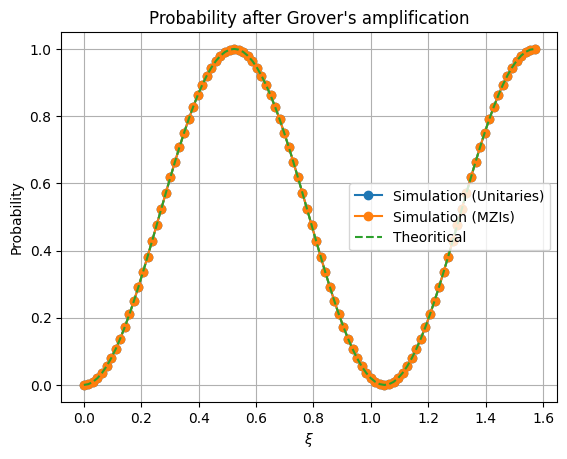

In [35]:
plt.plot(xis, results, "-o", label="Simulation (Unitaries)")
plt.plot(xis, results_mzis, "-o", label="Simulation (MZIs)")
plt.plot(xis, np.sin((3*xis)) ** 2, "--", label="Theoritical")
plt.title("Probability after Grover's amplification")
plt.xlabel("$\\xi$")
plt.ylabel("Probability")
plt.grid()
plt.legend()

## Reproducing the results of the paper

### Classical circuit

The classical circuit emulates the agent choosing a good action with probability $\varepsilon = \sin^2(\xi)$. To this end, the operation $U_p |0_A0_R\rangle = \cos(\xi)|0_A0_R\rangle + \sin(\xi)|1_A0_R\rangle$ is implemented putting the action state in a superposition with the corresponding amplitude. Then the interaction with the environment will make the second qubit switch only if the first qubit is in the state $|1_A\rangle$, hence putting the reward qubit in the $|1_R\rangle$ state.

![classical_circuit.png](../_static/img/reinforcement-learning_classical_circuit.png)

The detector D1, corresponding to $|0_A0_R\rangle$, will click with probability $\cos^2(\xi) = 1-\varepsilon$ and corresponds to no reward, whereas detector D2, corresponding to $|1_A1_R\rangle$, will click with probability $\sin^2(\xi) = \varepsilon$ and correspond to a rewarded action.

Both operations $U_p$ and $U_e$ were already implemented as part of the Grover's algorithm.

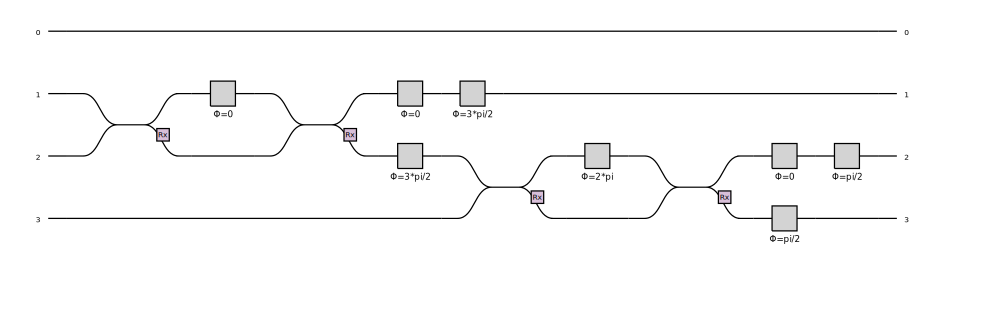

In [36]:
classical_circuit = pcvl.Circuit(4)
classical_circuit.add(1, state_prep).add(2, env) # circuit for classical strategy
pcvl.pdisplay(classical_circuit)

### Quantum circuit

The quantum circuit performs a Grover's amplification step in order to get the state closer to a rewarded state. However, during this step, no reward is ever perceived and a classical round is still needed afterward to check if the state is rewarded or not.

![quantum_circuit.png](../_static/img/reinforcement-learning_quantum_circuit.png)

We will here, directly append the classical circuit (without state preparation) to the quantum circuit, so that the whole operation is done with one circuits. Note that we will count this as being 2 epochs to have a fair comparison with the classical strategy.

![classical_quantum.png](../_static/img/reinforcement-learning_classical_quantum.png)

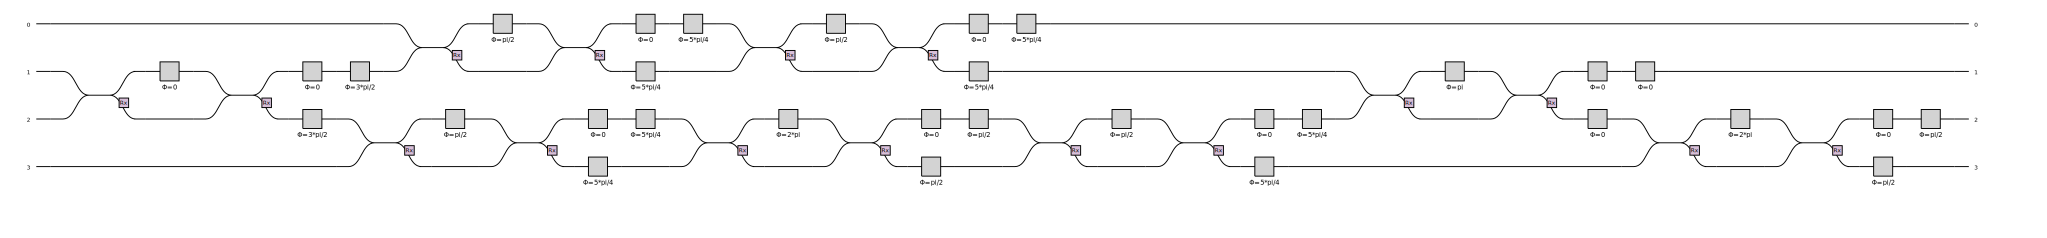

In [37]:
quantum_circuit = pcvl.Circuit(4)
quantum_circuit.add(1, state_prep).add(0, hadamard).add(2, hadamard).add(2, env).add(0, hadamard).add(2, hadamard).add(1, ref) #circuit for quantum strategy
quantum_circuit.add(2,env) #appending directly the classical round (without preparation) at the end
pcvl.pdisplay(quantum_circuit)

### Simulation

In [40]:
# Simulation parameters
N_AGENTS = 100 #number of agents that we simulate and average over
N_EPOCH = 1000
H_0 = 99
H_1 = 1
EPS0 = H_1 / (H_0+H_1)

#### Reward function
First we define a reward function that takes as an input a circuit, output a sample state and returns True if it corresponds to a rewarded state (False otherwise).

In [39]:
def get_reward(circuit: pcvl.Circuit) -> bool:
    proc = pcvl.Processor("SLOS", circuit)
    proc.with_input(pcvl.BasicState([0, 1, 0, 0]))
    sampler = pcvl.algorithm.Sampler(proc)
    samples = sampler.samples(1)

    # Take a random sample and check if it's the rewarded state or not
    return samples["results"][0] == pcvl.BasicState([0, 0, 0, 1])


#### Classical strategy

Below we gather everything defined above to run the purely classical strategy from the article.

In [20]:
eta_classical = []

# Pourcentage bar
f = FloatProgress(min=0, max=N_AGENTS)
display(f)

for agent in range(N_AGENTS): #Loop and average over all agents
    f.value = agent
    # Initialize initial score
    h_0 = H_0
    h_1 = H_1
    eps = h_1 / (h_0 + h_1)

    # Initialize circuit with initial probability and corresponding angles
    xi = np.arcsin(eps**0.5)
    
    theta1 = np.pi - 2*xi
    theta_prep.set_value(theta1)
    theta2_prep.set_value(-np.pi/2 - theta1/2)

    # Arrays of epsilon
    eps_array = []
    for i in range(N_EPOCH):
        if get_reward(classical_circuit): #update policy if output state corresponds to a rewarded state
            h_1 = h_1 + 2
            eps = h_1 / (h_0 + h_1)
            xi = np.arcsin(eps**0.5)
            theta1 = np.pi - 2*xi
            theta_prep.set_value(theta1)
            theta2_prep.set_value(-np.pi/2 - theta1/2)
            eps_array.append(1)
        else:
            eps_array.append(0)

    eta_classical.append(eps_array)

eta_classical = np.array(eta_classical)
f.value = N_AGENTS

FloatProgress(value=0.0)

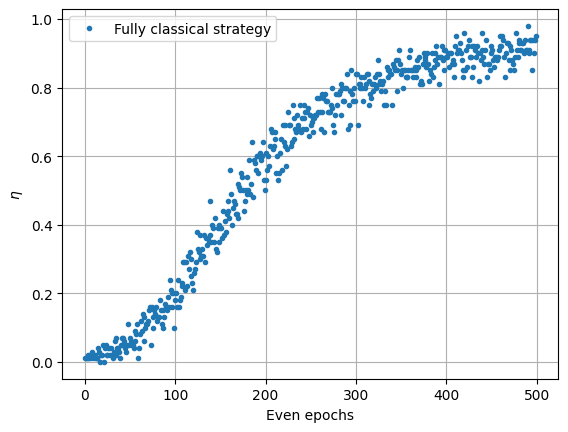

In [21]:
plt.plot(np.mean(eta_classical, axis=0)[::2], ".", label="Fully classical strategy")
plt.xlabel("Even epochs")
plt.ylabel("$\eta$")
plt.legend()
plt.grid()

Here we plot the proportion of agents that gets a reward. In the first epochs, the probability of getting a reward is small and few agents get some. However, once an agent gets a reward, they are more likely to get a reward in the future.

#### Quantum strategy

Below we run the purely quantum strategy.

In [22]:
eta_quantum = []

# Pourcentage bar
f = FloatProgress(min=0, max=N_AGENTS)
display(f)

for agent in range(N_AGENTS):
    f.value = agent
    # Initialize initial scores
    h_0 = H_0
    h_1 = H_1
    eps = h_1 / (h_0 + h_1)

    # Initialize circuit with initial probability
    xi = np.arcsin(eps**0.5)
    
    theta1 = np.pi - 2*xi
    theta_prep.set_value(theta1)
    theta2_prep.set_value(-np.pi/2 - theta1/2)
    
    theta2 = np.pi - 4*xi
    theta_ref.set_value(theta2)
    theta2_ref.set_value(-np.pi/2 - theta2/2)

    # Arrays of epsilon
    eps_array = []
    for i in range(N_EPOCH//2):
        if get_reward(quantum_circuit):
            h_1 = h_1 + 2
            eps = h_1 / (h_0 + h_1)
            xi = np.arcsin(eps**0.5)
            
            theta1 = np.pi - 2*xi
            theta_prep.set_value(theta1)
            theta2_prep.set_value(-np.pi/2 - theta1/2)
            
            theta2 = np.pi - 4*xi
            theta_ref.set_value(theta2)
            theta2_ref.set_value(-np.pi/2 - theta2/2)
            
            eps_array.append(0.5)
            eps_array.append(0.5)
        else:
            eps_array.append(0)
            eps_array.append(0)

    eta_quantum.append(eps_array)

eta_quantum = np.array(eta_quantum)
f.value=N_AGENTS

FloatProgress(value=0.0)

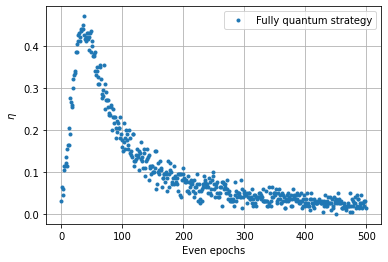

In [23]:
plt.plot(np.mean(eta_quantum, axis=0)[::2], ".", label="Fully quantum strategy")
plt.xlabel("Even epochs")
plt.ylabel("$\eta$")
plt.legend()
plt.grid()

Here we see a different behavior. With Grover's amplification, getting a reward is more likely in the first epochs. However, as the probability gets updated, one of Grover's amplification feature will manifest itself: we start to "overshoot" or rotate too much and we get past the winning state, and once we got past it, it is not possible to recover the winning state. We converge to a state with zero probability of getting a reward and nothing will get updated. This is why we need to consider an hybrid strategy.

#### Classical-quantum strategy

We want to start with a quantum strategy, and then switch to a classical strategy when e start to overshoot. This happens when the probability of winning in the quantum strategy gets lower than the classical one.

Due to normalization (and the fact that the quantum strategy takes twice as many epochs than the classical one), this corresponds to solve the equation

$$\frac{1}{2}\sin^2(3\xi) = \sin^2(\xi)$$

The solution can be found numerically and gives a value of $\xi = 0.6811$ which corresponds to $\varepsilon=\sin^2(\xi)=0.396$.

We then choose $Q_L$ to be the value where we switch from quantum to classical and the only requirement is $Q_L<0.396$. To follow [1] we will choose, $Q_L = 0.37$.

In [24]:
QL = 0.37
eta_classical_quantum = []

# Pourcentage bar
f = FloatProgress(min=0, max=N_AGENTS)
display(f)

for agent in range(N_AGENTS):
    f.value = agent
    # Initialize initial scores
    h_0 = H_0
    h_1 = H_1
    eps = h_1 / (h_0 + h_1)

    # Initialize circuit with initial probability
    xi = np.arcsin(eps**0.5)
    
    theta1 = np.pi - 2*xi
    theta_prep.set_value(theta1)
    theta2_prep.set_value(-np.pi/2 - theta1/2)
    
    theta2 = np.pi - 4*xi
    theta_ref.set_value(theta2)
    theta2_ref.set_value(-np.pi/2 - theta2/2)

    # Arrays of epsilon
    eps_array = []
    i = 0
    while i < N_EPOCH:
        if eps < QL:
            # Perform a quantum round
            if get_reward(quantum_circuit):
                h_1 = h_1 + 2
                eps = h_1 / (h_0 + h_1)
                xi = np.arcsin(eps**0.5)
                theta1 = np.pi - 2*xi
                theta_prep.set_value(theta1)
                theta2_prep.set_value(-np.pi/2 - theta1/2)
    
                theta2 = np.pi - 4*xi
                theta_ref.set_value(theta2)
                theta2_ref.set_value(-np.pi/2 - theta2/2)
                eps_array.append(0.5)
                eps_array.append(0.5)
            else:
                eps_array.append(0)
                eps_array.append(0)

            # Update epoch by 2
            i = i + 2
        else:
            # Perform a classical round
            if get_reward(classical_circuit):
                h_1 = h_1 + 2
                eps = h_1 / (h_0 + h_1)
                xi = np.arcsin(eps**0.5)
                theta1 = np.pi - 2*xi
                theta_prep.set_value(theta1)
                theta2_prep.set_value(-np.pi/2 - theta1/2)

                eps_array.append(1)
            else:
                eps_array.append(0)
            # Update epoch by 1
            i = i + 1

    eta_classical_quantum.append(eps_array)

eta_classical_quantum = np.array(eta_classical_quantum)
f.value=N_AGENTS

FloatProgress(value=0.0)

#### Plots

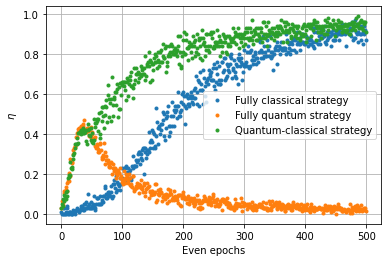

In [25]:
plt.plot(np.mean(eta_classical, axis=0)[::2], ".", label="Fully classical strategy")
plt.plot(np.mean(eta_quantum, axis=0)[::2], ".", label="Fully quantum strategy")
plt.plot(np.mean(eta_classical_quantum,axis=0,)[::2],".",label="Quantum-classical strategy",)
plt.xlabel("Even epochs")
plt.ylabel("$\eta$")
plt.legend()
plt.grid()

## Conclusion

Simulating the circuits of [1], we are able to reproduce their results. Data are still noisier than the results due to a smaller number agents. A parallelized version of this code was executed with 10 000 agents and the following results were found:

![results_10000.png](../_static/img/reinforcement-learning_results_10000.png)

which are very close to the paper results.

It's possible to play with the value of $Q_L$ and the number of agents. Remember that the simulation time is linear with the number of agents.

## Acknowledgement

This work was initially done during the Hackathon on Linear Optical Quantum Communication (LOQCathon) organised by [Quandela](https://www.quandela.com/) and [QICS](https://qics.sorbonne-universite.fr/en) (Quantum Information Center of Sorbonne Université), by the team composed of Luís Bugalho, Laura dos Santos Martins, Paolo Fittipaldi, Yoann Piétri and Verena Yacoub. The supervision was provided by Pierre-Emmanuel Emeriau.

## References

>  [1] V. Saggio, B. E. Asenbeck, A.  Hamann, et al. Experimental quantum speed-up in reinforcement learning agents. [Nature](https://doi.org/10.1038/s41586-021-03242-7), 591(7849), 229-233 (2021).

 > [2] A. Hamann, S. Wölk. Performance analysis of a hybrid agent for quantum-accessible reinforcement learning. [New Journal of Physics](https://doi.org/10.1088/1367-2630/ac5b56 ), 24(3), 033044 (2022).